
_"One of the fundamental properties of a control system is what set of points in the
state space can be reached through the choice of a control input. It turns out that the
property of reachability is also fundamental in understanding the extent to which
feedback can be used to design the dynamics of a system."_ -- Richard Murray.

In backward reachability analysis, the lower value of a differential game is used in constructing an analysis of the backward reachable set (or tube). We can cast a _target set_ as the time-resolved terminal value $V^-(x, T) = g(x(T))$ so that given a time bound, and an unsafe set of states, the time-bounded safety verification problem consists in certifying that there is no phase within the _target set_ that admits an unsafe set within the solution to the system of o.d.e's. We say the zero sublevel set of the terminal value function $g(\Omega)$, ($\Omega \in \mathbb{R}^n$) i.e.

\begin{align}
	\mathcal{L}_0 = \{ x \in \bar{\Omega} \,|\, g(x) \le 0 \},
\end{align}

is the _target set_ in the phase space $\Omega \times \mathbb{R}$. This target set can represent the failure set, regions of danger, or obstacles to be avoided etc in the state space. Note that the _target set_, $\mathcal{L}_0$, is a closed subset of $\mathbb{R}^n$ (whence, $\bar{\Omega}$ in the above) and is in the closure of $\Omega$. And the _robustly controlled backward reachable tube_ for $\tau \in [-T, 0]$ is the closure of the open set

\begin{align}
	\mathcal{L}([\tau, 0], \mathcal{L}_0) &= \{x \in \Omega \,| \, \exists \, \beta \in \mathcal{\bar{V}}(t) \,  \forall \, {u} \in \mathcal{U}(t), \exists \, \bar{t} \in [-T, 0], {\xi}(\bar{t})
	 \in  \mathcal{L}_0 \}, \,\bar{t} \in \left[-T, 0\right].
\end{align}

Read: the set of states from which the strategies of a player $P$, and for all controls of an opposing player $E$ imply that we reach the target set within the interval $[-T, 0]$.


In this notebook, we shall analytically and approximately (via level sets methods) solve for the 

+ Terminal state of the origin of the state plane when:

  + The Target set is an entire axis;
      -  This is important when we need the transients of the body to reach the origin in the _shortest possible time_.

  + The Target set is a line segment
      -  This is important when we need the transients of the body to reach an equilibrium other than the origin in the _shortest possible time_.

%% javascript MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber: "AMS" } } });

### Time-optimal control of a Double Integrator

The double integral plant is one of the simple systems we can use for analysis. It is called a double integrator because it is a second order o.d.e. It can represent the load in a frictionless environment where gravity is non-existent, for example. While this makes no engineering sense, it is useful for didactic purposes in analysing the large-scale system dynamics of interest to us.

Suppose we let $m$ be the mass (or inertial momentum) of a body, $x(t)$ its position (or angular displacement), and $\tau(t)$ the applied force, then by Newton's second law of motion, we have 

\begin{align}
    m \ddot{x}(t) = \tau(t).
\end{align}

Let us write (our control law) $u(t) = \tau(t)/m$, so that we have

\begin{align}
  \ddot{x}(t) = u(t).
\end{align}

If we consider the following change of variables,

\begin{align}
  {x}_1(t) &= x(t) \\
  {x}_2(t) &= \dot{x}(t),
\end{align}

then, we can then represent the double integral plant system as the following system of first-order o.d.e's:

\begin{align}
  \dot{x}_1(t) &= x_2(t) \\
  \dot{x}_2(t) &= u(t).
\end{align}

Let $u(t)$ be bounded as follows $|u(t)| \le 1$ for all time $t$. This can be e.g. as a result of limitations on the amount of effort we want to give to our actuator. We now redefine the problem to be solved as follows:

\begin{align}
  \dot{x}_1(t) &= x_2(t) \\
  \dot{x}_2(t) &= u(t) \qquad \qquad |u(t)| \le 1.
\end{align}

The statement of the problem at hand is to _find an admissible control that forces the above system from any initial state $\left[\xi_1, \xi_2\right]$ to the origin (0,0) in the shortest possible time._


Observe:

+ $u$, the control law, is discontinuous. 

+ This dynamical system is reminiscent of differential equations with discontinuous 
right hand sides. 

    + They admit what we call Fillipov solutions, named after Alexei Fillipov [Died 2006].

Let us now import a set of tools that will aid us in constructing the state space, _inter alia_.

In [1]:
import sys
import copy
import time
import cupy as cp
import numpy as np
import scipy.linalg as la
from os.path import abspath, join
import matplotlib.pyplot as plt

from os.path import abspath, join, expanduser
sys.path.append(abspath(join('..')))
from BRATVisualization.DIVisu import DoubleIntegratorVisualizer
sys.path.append(abspath(join('../..')))

# Pull Mister Molux's Libraries
from LevelSetPy.Utilities import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator

# POD Decomposition
from LevelSetPy.POD import *

# Lekan's Chambolle-Pock impl. for Total Variation De-Noising
from LevelSetPy.Optimization import chambollepock

# Value co-state and Lax-Friedrichs upwinding schemes
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF, odeCFL2, \
            odeCFLset,termRestrictUpdate, termLaxFriedrichs

### Create state space and value function.

+ This would be the grid upon which we are going to control 
the car/unicycle etc -- basically anything that may have 
double integrator dynamics.

+ In addition, we'll generate the analytical solution to the time to reach the origin problem on the grid. Let's call this variable `attr`. 

+ Our initial value function will be constructed as an implicit function on the grid with a signed distance function in the geometry of a sphere of radius, $r$.

In [2]:
dint = DoubleIntegrator
u_bound = 1

In [3]:

def preprocessing():
    global dint, u_bound

    gmin = np.array(([[-1, -1]]),dtype=np.float64).T
    gmax = np.array(([[1, 1]]),dtype=np.float64).T
    g = createGrid(gmin, gmax, 101, None)

    eps_targ = 1.0
    target_rad = .2

    dint = DoubleIntegrator(g, u_bound)
    attr = dint.mttr() - target_rad
    if strcmp(args.init_cond, 'attr'):
        value_func_init = attr
    elif strcmp(args.init_cond, 'circle'):
        value_func_init = shapeSphere(g, zeros(g.dim, 1), target_rad)
    elif strcmp(args.init_cond, 'square'):
        value_func_init = shapeRectangleByCenter(g, zeros(g.dim, 1), \
                                    2*target_rad*ones(g.dim,1))

    attr = np.maximum(0, attr)

    return g, attr, value_func_init


In [6]:
def show_init_levels(g, attr, value_func_init):

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))

    ax1.contour(g.xs[0], g.xs[1], attr, colors='m')
    ax1.set_title('Analytical TTR')
    ax1.set_xlabel(r"$x_1 (m)$")
    ax1.set_ylabel(r"$x_2 (ms^{-1})$")
    ax1.set_xlim([-1.02, 1.02])
    ax1.set_ylim([-1.01, 1.01])
    ax1.grid()

    ax2.contour(g.xs[0], g.xs[1], value_func_init, colors='blue')
    ax2.set_title('Numerical TTR')
    ax2.set_xlabel(r"$x_1 (m)$")
    ax2.set_xlim([-1.02, 1.02])
    ax2.set_ylim([-1.01, 1.01])
    ax2.grid()

    f.suptitle(f"Levelsets")

    f.canvas.draw()
    f.canvas.flush_events()
    time.sleep(args.pause_time)

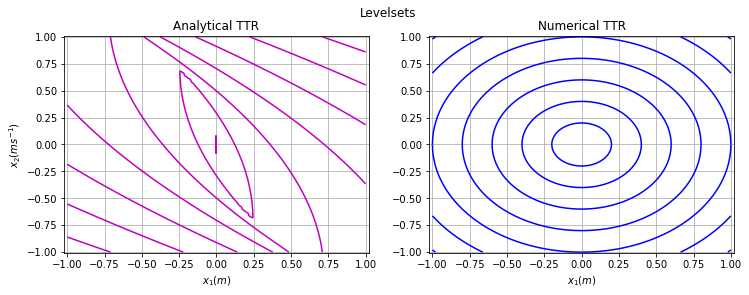

In [7]:
args = Bundle(dict(init_cond='circle', visualize=True, pause_time=1))
g, attr, value_func_init = preprocessing()
show_init_levels(g, attr, value_func_init)

#### Trajectories in the $x_1$-$x_2$ plane

\begin{align}
x_1 &= \xi_1 + \frac{1}{2} \Delta x_2^2 - \frac{1}{2} \Delta \xi_2^2, \text{ where } \quad t = \Delta(x_2 - \xi_2)  \\
x_2 &= \xi_2 + \Delta t
\end{align}

where $\Delta= u \equiv \pm 1$, 

$t$ is the time it takes to arrive at our goal; 

and $x_1$ and $x_2$ are the position and velocity of the body respectively.

In [46]:

fontdict = {'fontsize':28, 'fontweight':'bold'}
def show_trajectories(g, attr, x_i):
	### pick a bunch of initial conditions
	Δ = lambda u: u  # u is either +1 or -1
	
	# how much timesteps to consider
	t = np.linspace(-1, 1, 100)
	# do implicit euler integration to obtain x1 and x2
	x1p = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2p = np.empty((len(x_i), g.xs[1].shape[1], len(t)))
	# states under negative control law
	x1m  = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2m = np.empty((len(x_i), g.xs[1].shape[1], len(t)))

	fig, ax1 = plt.subplots(1, 1, figsize=(25,14))

	for i in range(len(x_i)):
		for k in range(len(t)):
			# state trajos under +ve control law
			x2p[i, :,k] = x_i[i][1] + Δ(u_bound) * t[k]
			x1p[i, :,k] = x_i[i][0] + .5 * Δ(u_bound) * x2p[i,:,k]**2 - .5 * Δ(u_bound) * x_i[i][1]**2
			# state trajos under -ve control law
			x2m[i, :,k] = x_i[i][1] + Δ(-u_bound) * t[k]
			x1m[i, :,k] = x_i[i][0]+.3 + .5 * Δ(-u_bound) * x2p[i,:,k]**2 - .5 * Δ(-u_bound) * x_i[i][1]**2


	# Plot a few snapshots for different initial conditions.
	color = iter(plt.cm.inferno_r(np.linspace(.25, 1, 2*len(x_i))))
	# repeat for legends
	for init_cond in range(0, len(x_i)):
		# state trajectories are unique for every initial cond
		# here, we pick the last state
		ax1.plot(x1p[init_cond, -1, :], x2p[init_cond, -1, :], linewidth=3, color=next(color), \
			label=rf"x$_{init_cond+1}^+={x_i[init_cond]}$")
		ax1.plot(x1m[init_cond, -1, :], x2m[init_cond, -1, :], '-.', linewidth=3, color=next(color) , \
			label=rf"x$_{init_cond+1}^-={x_i[init_cond]}$")

		#plot the quivers
		ax1.grid('on')
		up, vp = x2p[init_cond, -1, ::len(t)//2], [Δ(u_bound)]*len(x2p[init_cond, -1, ::len(t)//2])
		um, vm = x2m[init_cond, -1, ::len(t)//2], [Δ(-u_bound)]*len(x2m[init_cond, -1, ::len(t)//2])
		ax1.quiver(x1p[init_cond, -1, ::len(t)//2], x2p[init_cond, -1, ::len(t)//2], up, vp, angles='xy')
		ax1.quiver(x1m[init_cond, -1, ::len(t)//2], x2m[init_cond, -1, ::len(t)//2], um, vm, angles='xy')

	ax1.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax1.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_title(rf"Example State Trajectories.", fontdict=fontdict)
	ax1.legend(loc="center left", fontsize=14) 
	
	fig.savefig(join(expanduser("~"),"Documents/Papers/Pubs23/LevPy", "figures/doub_int_trajos.jpg"), 
                bbox_inches='tight',facecolor='None')
	# fig.canvas.draw()
	# fig.canvas.flush_events()
	time.sleep(args.pause_time)


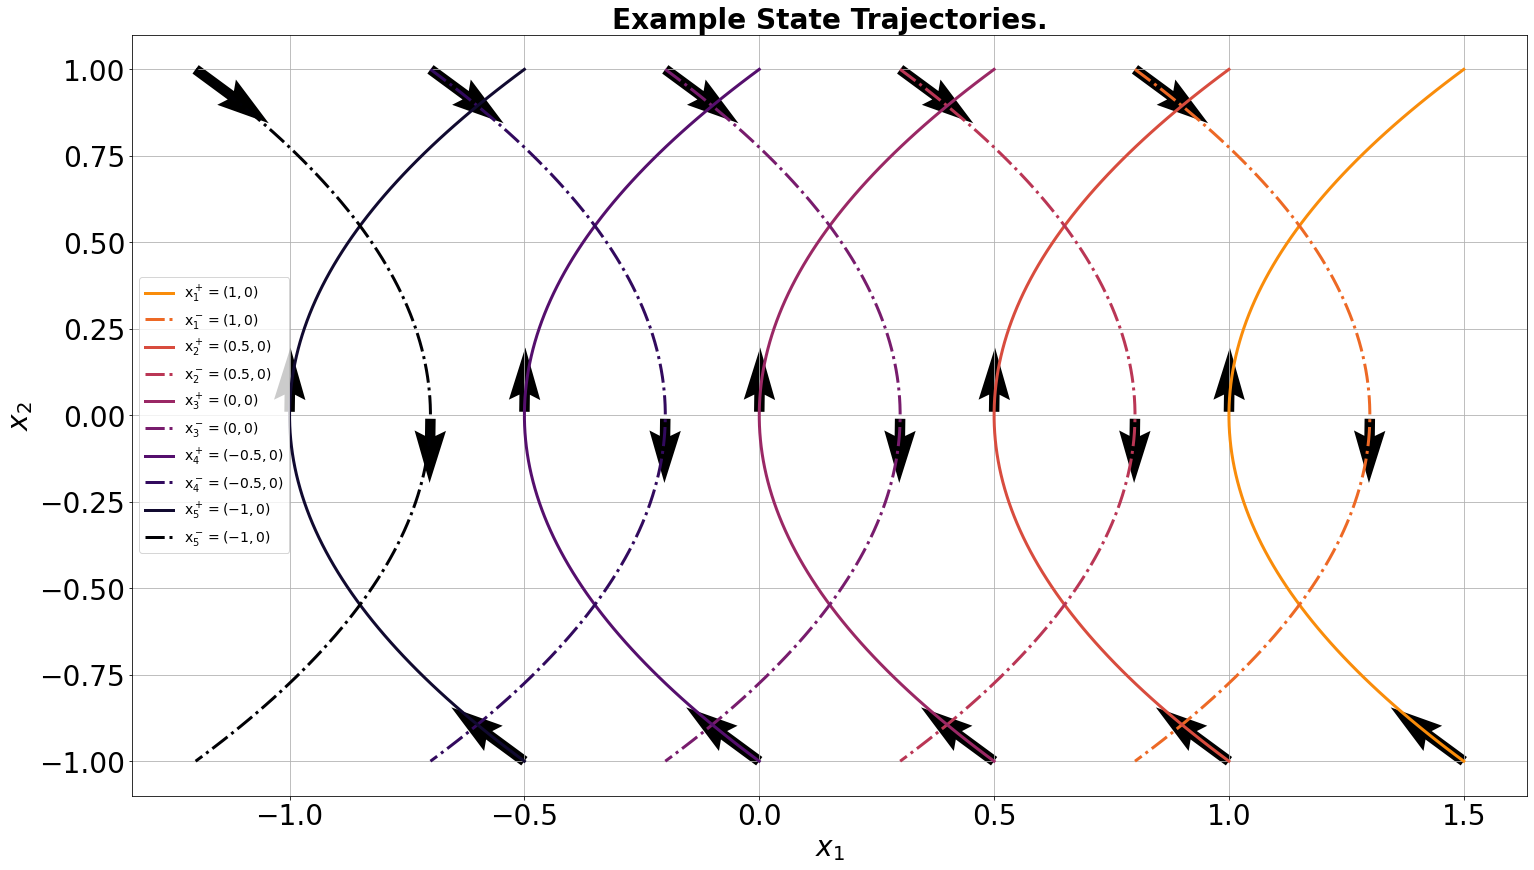

In [47]:
xis = [(1,0), (.5, 0),  (0,0), (-.5, 0), (-1,0)]

# xis = [(.5, 0),  (0.,0),  (-.5, 0)]
show_trajectories(g, attr, xis)

In [28]:
### Plot the switching curve
fontdict = {'fontsize':42, 'fontweight':'bold'}
def show_switch_curve():
	# Plot all vectograms(snapshots) in space and time.
	fig3, ax3 = plt.subplots(1, 1, figsize=(14,13))
	ax3.grid('on')
	color = iter(plt.cm.seismic_r(np.linspace(.25, 1, 4)))
	ax3.plot(dint.Gamma[0,:], linewidth=7.5, color=next(color), label=rf"Switching Curve, $\gamma$")
	xmin, xmax = ax3.get_xlim()
	ymin, ymax = ax3.get_ylim()
	ax3.hlines(0, xmin, xmax, colors='black', linestyles='solid', label='')
	ax3.vlines(len(dint.Gamma)//2, ymin, ymax, colors='black', linestyles='solid', label='')

	ax3.set_xlim(0, 100)
	ax3.set_ylim(-.55, .55)

	ax3.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax3.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax3.set_title(rf"Switching Curve, $\gamma$", fontdict=fontdict)
	ax3.tick_params(axis='both', which='major', labelsize=42)
	ax3.tick_params(axis='both', which='minor', labelsize=22)
	ax3.legend(fontsize=28)			
	plt.tight_layout()

	# fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
	fig3.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/switching_curve.jpg"),
				bbox_inches='tight',facecolor='None')

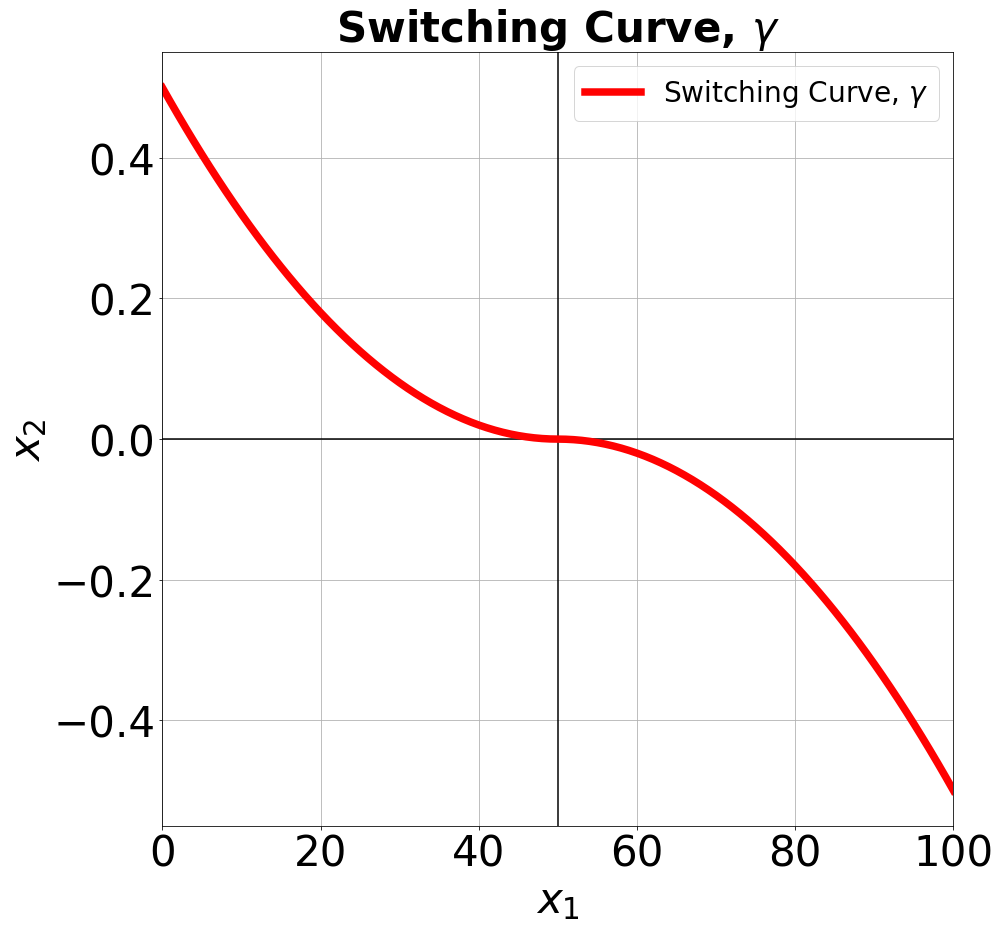

In [9]:
show_switch_curve()

### Plot the Analytical Time to Reach the origin


In [48]:
def show_attr():
    # Plot all vectograms(snapshots) in space and time.
    fig2, ax2 = plt.subplots(1, 1, figsize=(16,9))
    cdata = ax2.pcolormesh(g.xs[0], g.xs[1], attr, shading="nearest", cmap="magma_r")
    plt.colorbar(cdata, ax=ax2, extend="both")
    ax2.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
    ax2.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
    ax2.set_title(r"Reach Time", fontdict=fontdict)
    ax2.tick_params(axis='both', which='major', labelsize=28)
    ax2.tick_params(axis='both', which='minor', labelsize=18)

    # fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
    fig2.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/attr.jpg"),
                bbox_inches='tight',facecolor='None')


### Examining the Level Sets

The analytical time-to-reach is resolved as

\begin{align}
  &\left[\left(x_2 + \sqrt{4 x_1 + 2 x_2^2}\right) \, \cdot \, \left(x_1 > \Gamma\right)\right] + 
            &\left[\left(-x_2 + \sqrt{2x_2^2 - 4 x_1}\right)  \, \cdot \,  (x_1 < \Gamma) \right] +
            |x_2|  \, \cdot \,  \left(x_1 = \Gamma\right).
\end{align}

where $\Gamma$ is the switching curve defined as 

\begin{align}
    \Gamma = -\dfrac{1}{2} \cdot x_2 \dot |x_2|
\end{align}

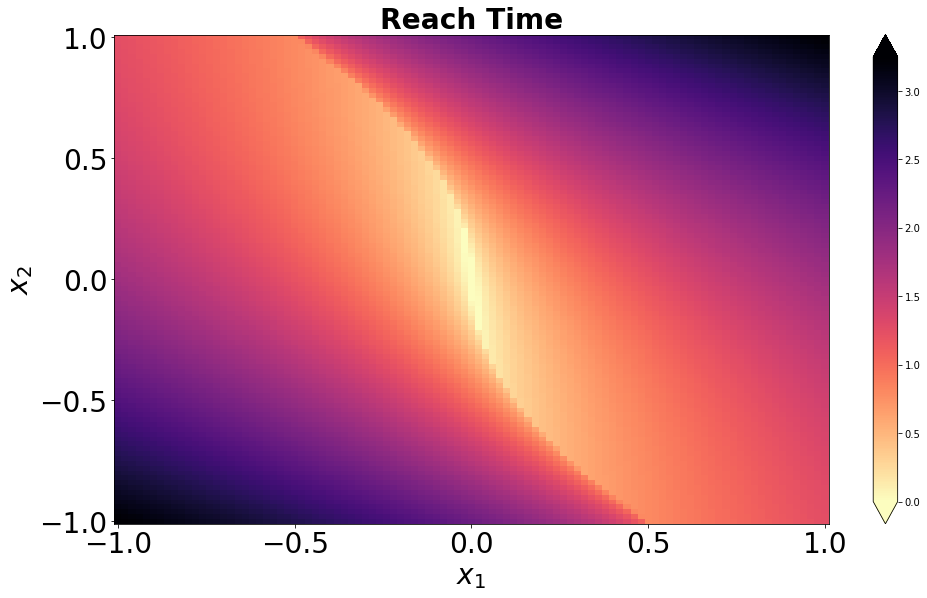

In [49]:
show_attr()

Let us consider the set of states that can be forced to the origin in the same minimum time $t^\star$. 

This is otherwise termed the _isochrones_ of the set $S(t^\star)$ at $t^\star$.

This is given by 

\begin{align}
   x_1 &= -\dfrac{1}{2} x_2^2 + \dfrac{1}{4}(t^\star - x_2)^2   \quad &for \quad x_1 > -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= -\dfrac{1}{2} x_2 - \dfrac{1}{4}(t^\star + x_2)^2   \quad &for \quad x_1 < -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= x_1 - \dfrac{1}{2} x_2 t^\star   \quad &for \quad x_1 = -\dfrac{1}{2} x_2 |x_2| 
\end{align}

In [50]:
def isochoner(tstar = 0.5):
    above_curve = (-.5 * dint.grid.xs[1]**2 + .25*  (tstar - dint.grid.xs[1])**2 )*(dint.grid.xs[0]>dint.Gamma)
    below_curve = (.5 * dint.grid.xs[1]**2 - .25 * (tstar +  dint.grid.xs[1])**2 )*(dint.grid.xs[0]<dint.Gamma)
    on_curve =  (-.5 * (dint.grid.xs[1] * tstar))*(dint.grid.xs[0]==dint.Gamma)

    return above_curve, below_curve, on_curve

tt = dint.mttr()
above_curve, below_curve, on_curve = isochoner(tt)
isochrones = above_curve+below_curve+on_curve

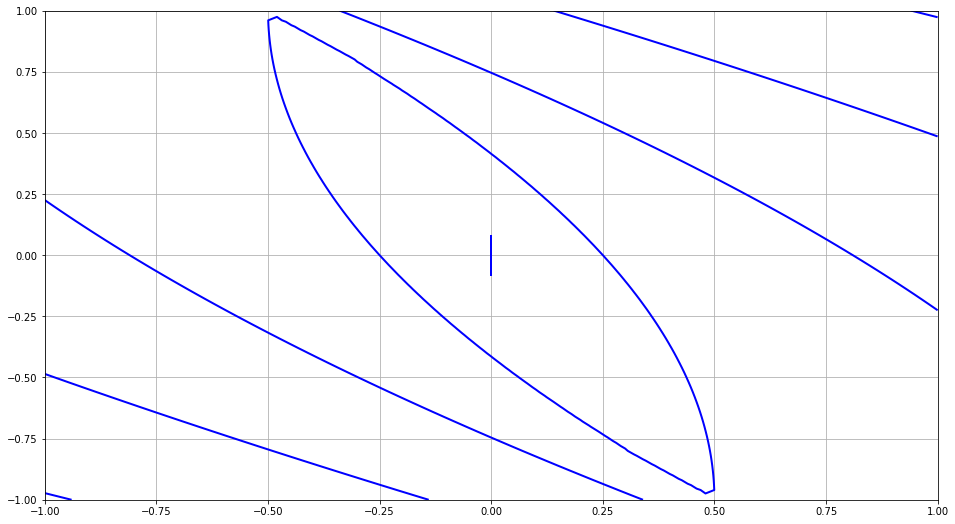

In [51]:
f, ax = plt.subplots(1, 1, figsize=(16,9))
ax.grid('on')
ax.contour(dint.grid.xs[0], dint.grid.xs[1], attr, levels=4, colors='b', origin='upper', linewidths=2)
plt.show()

### Optimize the trajectories

In [52]:
global dint, u_bound
#turn the state space over to the gpu
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':g,
                'hamFunc': dint.hamiltonian,
                'partialFunc': dint.dynamics,
                'dissFunc': artificialDissipationGLF,
                'derivFunc': upwindFirstENO2,
                }),
                positive = False,  # direction to grow the updated level set
            ))

small = 100*eps
t_span = np.linspace(0, 2.0, 20)
options = Bundle(dict(factorCFL=0.75, stats='on', maxStep=realmax, 						singleStep='off', postTimestep=postTimeStepTTR))

y = copy.copy(value_func_init.flatten())
y, finite_diff_data = postTimeStepTTR(0, y, finite_diff_data)
value_func = cp.asarray(copy.copy(y.reshape(g.shape)))

CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [ ]:
# Visualization paramters
spacing = tuple(g.dx.flatten().tolist())
params = Bundle(
					{'grid': g,
					#'pgd_grid': g,
					'disp': True,
					'labelsize': 16,
					'labels': "Initial 0-LevelSet",
					'linewidth': 2,
					'mesh': value_func.get(),
					'pgd_mesh': value_func.get(),
					'init_conditions': False,
					'pause_time': args.pause_time,
					'level': 0, # which level set to visualize
					'winsize': (16,9),
					'fontdict': Bundle({'fontsize':12, 'fontweight':'bold'}),
					"savedict": Bundle({"save": False,
								"savename": "rcbrt",
								"savepath": "../jpeg_dumps/rcbrt"})
					})

if args.visualize:
	viz = DoubleIntegratorVisualizer(params)

value_func_all = np.zeros((len(t_span),)+value_func.shape)

cur_time, max_time = 0, t_span[-1]
step_time = (t_span[-1]-t_span[0])/8.0

start_time = cputime()
itr_start = cp.cuda.Event()
itr_end = cp.cuda.Event()

idx = 0
while max_time-cur_time > small * max_time:
	itr_start.record()
	cpu_start = cputime()

	time_step = f"{cur_time:.2f}/{max_time:.2f}"

	y0 = value_func.flatten()

	#How far to integrate
	t_span = np.hstack([cur_time, min(max_time, cur_time + step_time)])

	# advance one step of integration
	t, y, finite_diff_data = odeCFL2(termRestrictUpdate, t_span, y0, options, finite_diff_data)
	cp.cuda.Stream.null.synchronize()
	cur_time = t if np.isscalar(t) else t[-1]

	value_func = cp.reshape(y, g.shape)

	if args.visualize:
		ls_mesh = value_func.get()
		viz.update_tube(attr, ls_mesh, ls_mesh, cur_time, delete_last_plot=True)

	itr_end.record()
	itr_end.synchronize()
	cpu_end = cputime()

	print(f't: {time_step} | GPU time: {(cp.cuda.get_elapsed_time(itr_start, itr_end)):.2f} | CPU Time: {(cpu_end-cpu_start):.2f}')

	# store this brt
	value_func_all[idx] = ls_mesh
	idx += 1

end_time = cputime()
print(f'Total BRS/BRT execution time {(end_time - start_time):.4f} seconds.')

NameError: name 'value_func' is not defined